In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time

import subprocess

# Larger figure size
fig_size = [10, 6]
plt.rcParams['figure.figsize'] = fig_size

In [3]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

def unixtimestamp2mjd(u):
    return u / seconds_in_day + mjd_unixtimestamp_offset

In [4]:
def load_orbit_file(path):
    ncols = 8
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

Keys for each of the columns in the orbit (Keplerian state) report.

In [5]:
utc = 0
sma = 1
ecc = 2
inc = 3
raan = 4
aop = 5
ma = 6
ta = 7

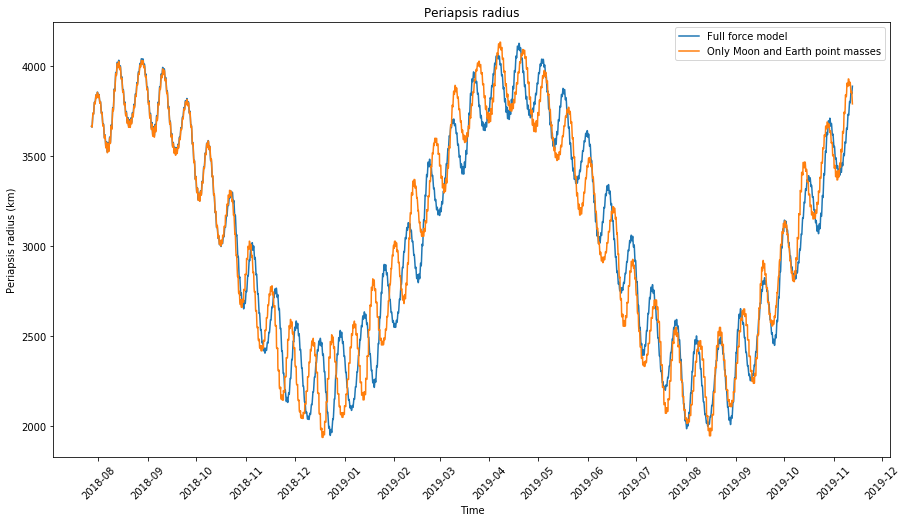

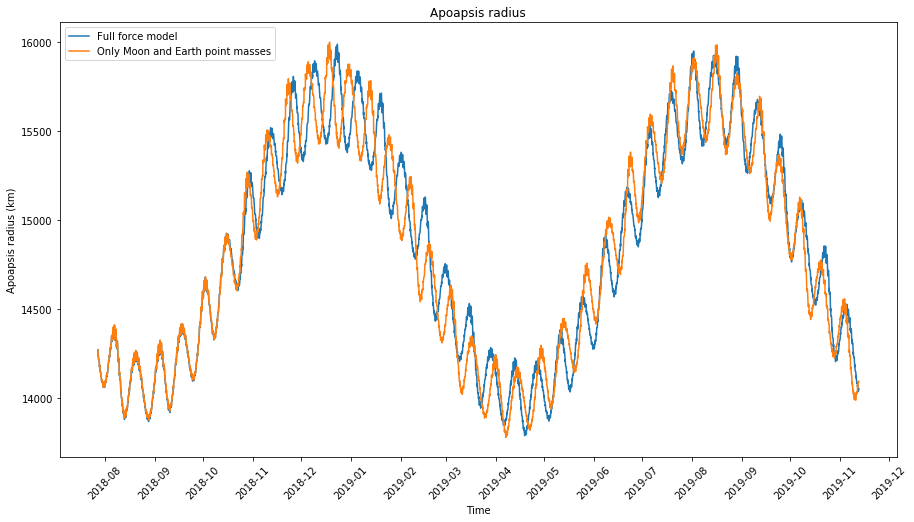

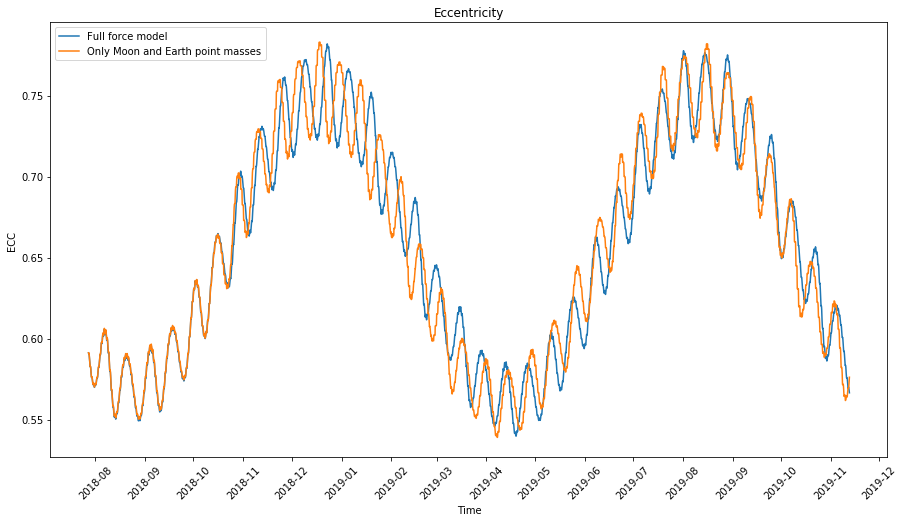

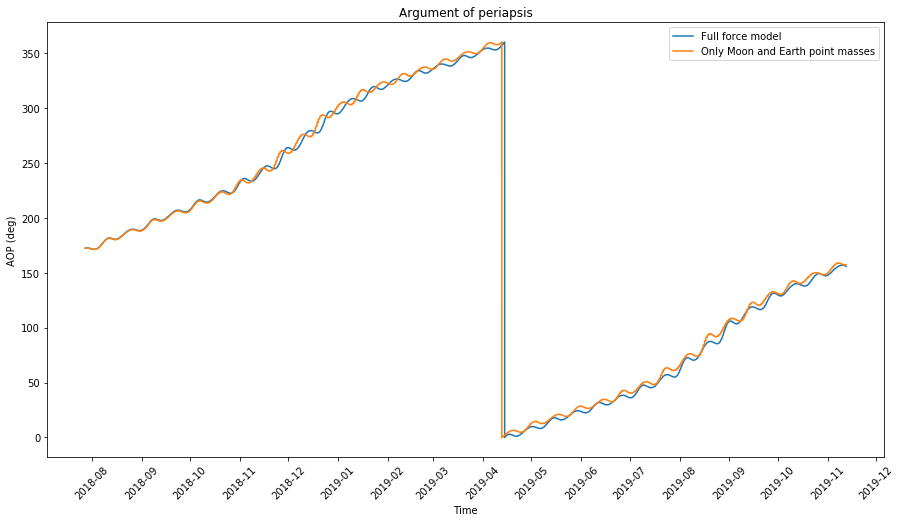

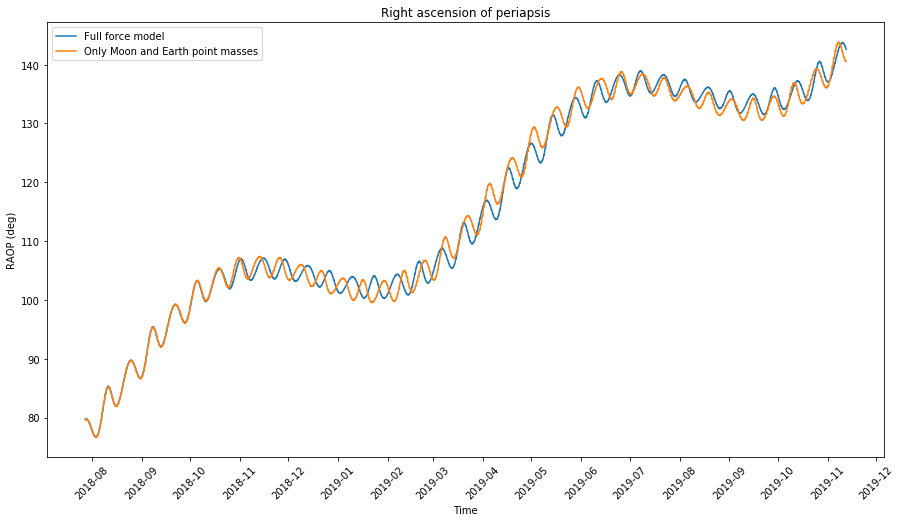

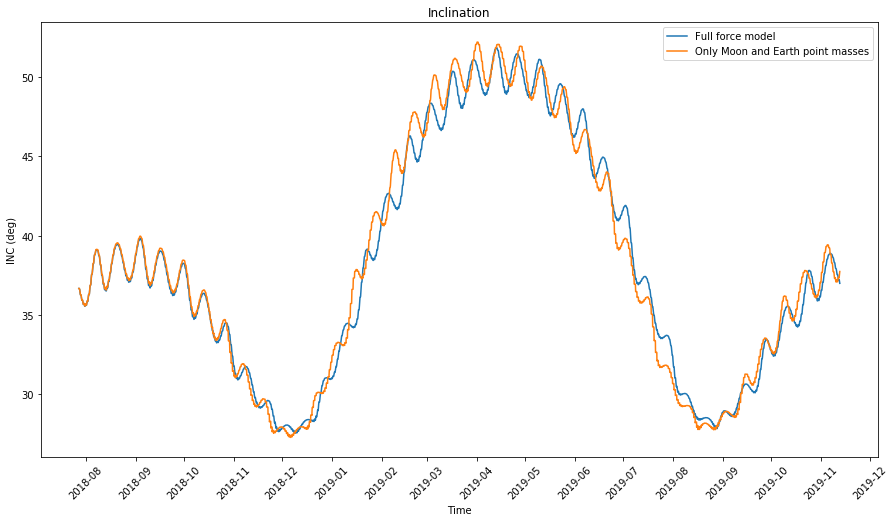

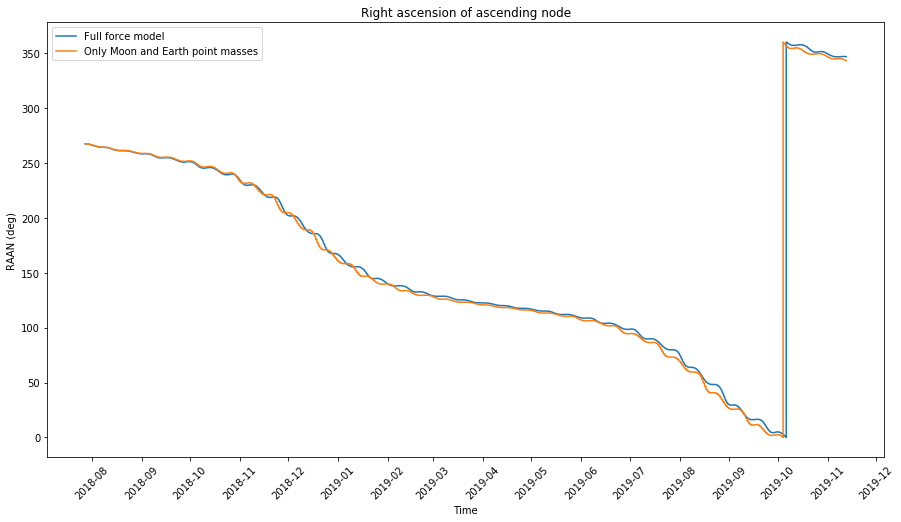

In [6]:
fig_peri = plt.figure(figsize = [15,8], facecolor='w')
fig_apo = plt.figure(figsize = [15,8], facecolor='w')
fig3 = plt.figure(figsize = [15,8], facecolor='w')
fig4 = plt.figure(figsize = [15,8], facecolor='w')
fig4_rap = plt.figure(figsize = [15,8], facecolor='w')
fig5 = plt.figure(figsize = [15,8], facecolor='w')
fig6 = plt.figure(figsize = [15,8], facecolor='w')

sub_peri = fig_peri.add_subplot(111)
sub_apo = fig_apo.add_subplot(111)
sub3 = fig3.add_subplot(111)
sub4 = fig4.add_subplot(111)
sub4_rap = fig4_rap.add_subplot(111)
sub5 = fig5.add_subplot(111)
sub6 = fig6.add_subplot(111)

subs = [sub_peri, sub_apo, sub3, sub4, sub4_rap, sub5, sub6]

for file in ['dslwp_report.txt', 'dslwp_report_simple.txt']:
    orbit = load_orbit_file(file)

    t = Time(mjd2unixtimestamp(orbit[:,utc]), format='unix')

    sub_peri.plot(t.datetime, orbit[:,sma]*(1-orbit[:,ecc]))

    sub_apo.plot(t.datetime, orbit[:,sma]*(1+orbit[:,ecc]))
    sub3.plot(t.datetime, orbit[:,ecc])
    sub4.plot(t.datetime, orbit[:,aop])
    sub4_rap.plot(t.datetime, np.fmod(orbit[:,aop] + orbit[:,raan],360))
    sub5.plot(t.datetime, orbit[:,inc])
    sub6.plot(t.datetime, orbit[:,raan])

month_locator = mdates.MonthLocator()
day_locator = mdates.DayLocator()

for sub in subs:
    sub.set_xlabel('Time')
    sub.xaxis.set_major_locator(month_locator)
    sub.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    sub.xaxis.set_tick_params(rotation=45)

sub_peri.set_ylabel('Periapsis radius (km)')
sub_apo.set_ylabel('Apoapsis radius (km)')
sub3.set_ylabel('ECC')
sub4.set_ylabel('AOP (deg)')
sub4_rap.set_ylabel('RAOP (deg)')
sub5.set_ylabel('INC (deg)')
sub6.set_ylabel('RAAN (deg)')

sub_peri.set_title('Periapsis radius')
sub_apo.set_title('Apoapsis radius')
sub3.set_title('Eccentricity')
sub4.set_title('Argument of periapsis')
sub4_rap.set_title('Right ascension of periapsis')
sub5.set_title('Inclination')
sub6.set_title('Right ascension of ascending node')

for sub in subs:
    sub.legend(['Full force model', 'Only Moon and Earth point masses'])

In [7]:
mu_1 = 3.986004418e14 # Earth's gravitational constant
mu_0 = 4.9048695e12 # Moon's gravitational parameter

In [8]:
orbit = load_orbit_file('dslwp_report_earth.txt')
t = Time(mjd2unixtimestamp(orbit[:,utc]), format='unix')

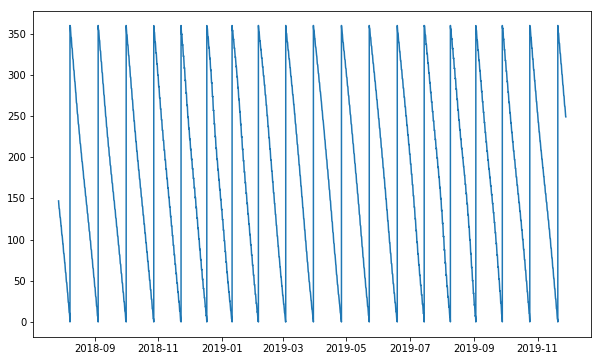

In [9]:
plt.plot(t.datetime, orbit[:,raan])

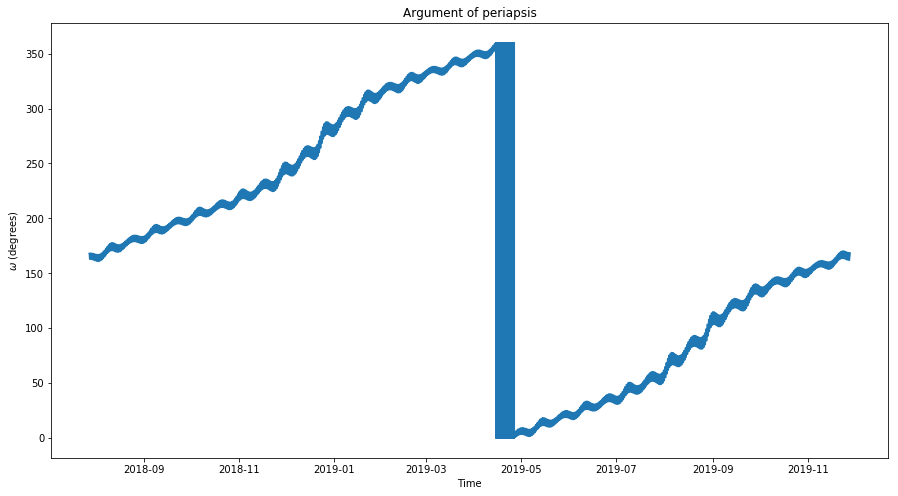

In [45]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, orbit[:,aop])
plt.xlabel('Time')
plt.ylabel('$\omega$ (degrees)')
plt.title('Argument of periapsis');

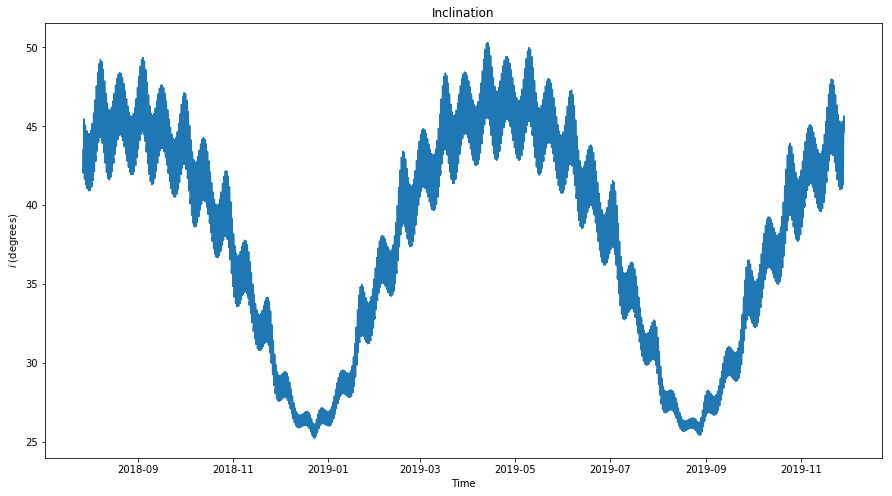

In [11]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, orbit[:,inc])
plt.xlabel('Time')
plt.ylabel('$i$ (degrees)')
plt.title('Inclination');

In [12]:
Omega = orbit[:,raan]/180*np.pi
w = orbit[:,aop]/180*np.pi
i = orbit[:,inc]/180*np.pi
xi_1 = np.cos(Omega)*np.cos(w) - np.sin(Omega)*np.cos(i)*np.sin(w)
xi_2 = -np.cos(Omega)*np.sin(w) - np.sin(Omega)*np.cos(i)*np.cos(w)
xi_3 = np.sin(Omega)*np.sin(i)
beta_1 = xi_1**2
beta_2 = xi_2**2
beta_3 = xi_1*xi_2
beta_4 = xi_2*xi_3
beta_5 = xi_1*xi_3

In [13]:
a = 8960 # SMA in km
P = 2*np.pi*np.sqrt((1e3*a)**3/mu_0)/(24*3600) # period in days
e = 0.67 # mean eccentricity
i_avg = 0.64 # mean inclination
r_1 = 384400 # mean Earth-Moon distance

In [14]:
def integrate_delta(x):
    return np.concatenate((np.array([0]), np.cumsum(x[:-1]/P*np.diff(orbit[:,utc]))))

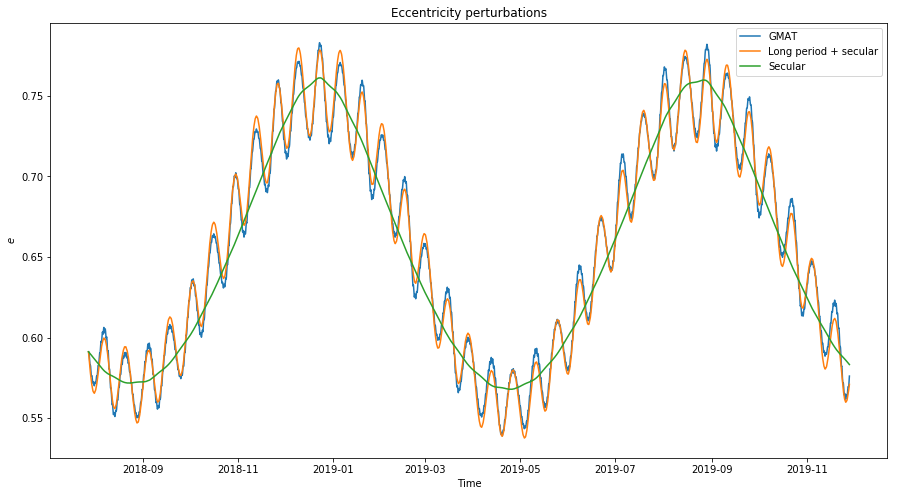

In [15]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, orbit[:,ecc])
delta_e_secular = 15/4*np.pi*mu_1/mu_0*(a/r_1)**3*e*np.sqrt(1-e**2)*np.sin(i_avg)**2*np.sin(2*w)
delta_e_complete= -15*np.pi*mu_1/mu_0*(a/r_1)**3*e*np.sqrt(1-e**2)*beta_3
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_complete))
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_secular))
plt.legend(['GMAT', 'Long period + secular', 'Secular'])
plt.xlabel('Time')
plt.ylabel('$e$')
plt.title('Eccentricity perturbations');

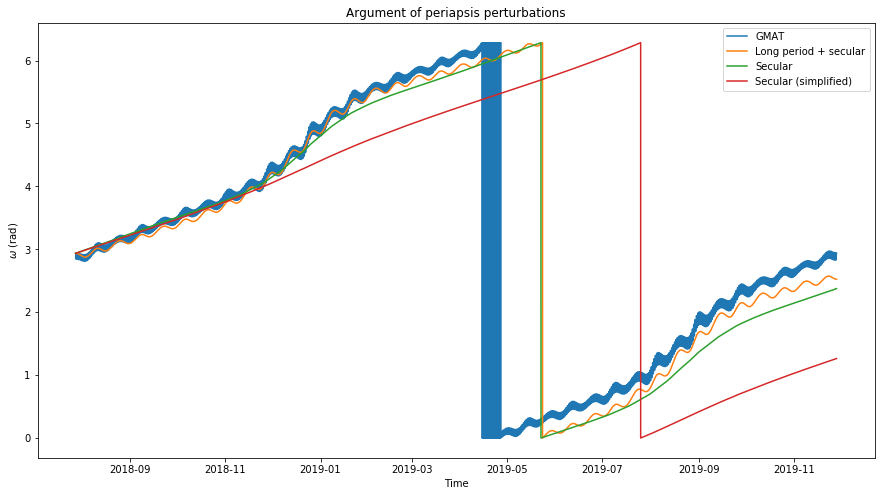

In [46]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, w)
delta_w_secular = 3/2*np.pi*mu_1/mu_0*(a/r_1)**3*1/np.sqrt(1-orbit[:,ecc]**2)*(5*np.cos(i)**2*np.sin(w)**2 + (1-orbit[:,ecc]**2)*(2-5*np.sin(w)**2))
delta_w_secular_simple = 3/2*np.pi*mu_1/mu_0*(a/r_1)**3*1/np.sqrt(1-e**2)*(5*np.cos(i_avg)**2*np.sin(w)**2 + (1-e**2)*(2-5*np.sin(w)**2))
delta_w_complete = 3*np.pi*mu_1/mu_0*(a/r_1)**3*(np.sqrt(1-orbit[:,ecc]**2)*(4*beta_1-beta_2-1) - 1/(np.sqrt(1-orbit[:,ecc]**2)*np.sin(i))*((1+4*orbit[:,ecc]**2)*beta_5*np.sin(w)+(1-orbit[:,ecc]**2)*beta_4*np.sin(w)))
w_secular_est = w[0]+integrate_delta(delta_w_secular)
w_secular_simple_est = w[0]+integrate_delta(delta_w_secular_simple)
w_complete_est = w[0]+integrate_delta(delta_w_complete)
plt.plot(t.datetime, np.fmod(w_complete_est, 2*np.pi))
plt.plot(t.datetime, np.fmod(w_secular_est, 2*np.pi))
plt.plot(t.datetime, np.fmod(w_secular_simple_est, 2*np.pi))
plt.legend(['GMAT', 'Long period + secular', 'Secular', 'Secular (simplified)'])
plt.xlabel('Time')
plt.ylabel('$\omega$ (rad)')
plt.title('Argument of periapsis perturbations');

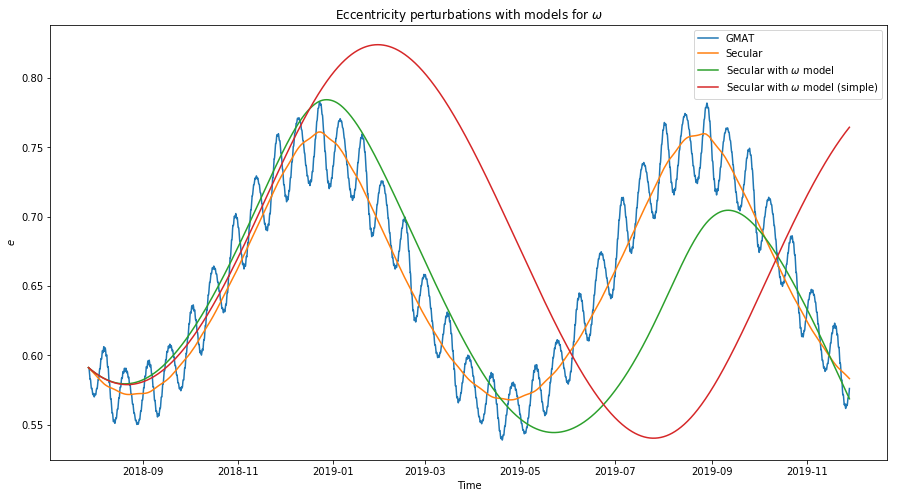

In [17]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, orbit[:,ecc])
delta_e_secular_model = 15/4*np.pi*mu_1/mu_0*(a/r_1)**3*e*np.sqrt(1-e**2)*np.sin(i_avg)**2*np.sin(2*w_secular_est)
delta_e_secular_model_simple = 15/4*np.pi*mu_1/mu_0*(a/r_1)**3*e*np.sqrt(1-e**2)*np.sin(i_avg)**2*np.sin(2*w_secular_simple_est)
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_secular))
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_secular_model))
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_secular_model_simple))
plt.legend(['GMAT', 'Secular', 'Secular with $\omega$ model', 'Secular with $\omega$ model (simple)'])
plt.xlabel('Time')
plt.ylabel('$e$')
plt.title('Eccentricity perturbations with models for $\omega$');

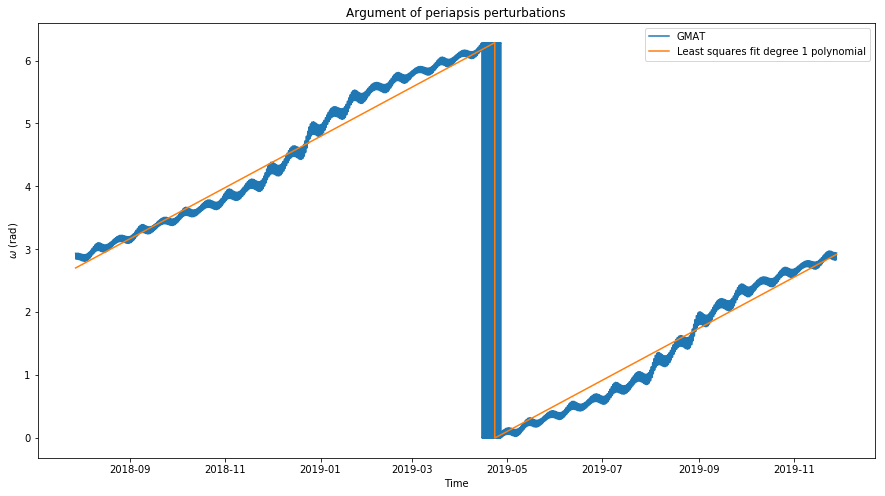

In [47]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, w)
p_w = np.polyfit(orbit[:,utc]-orbit[0,utc], np.unwrap(w), 1)
w_lsq = np.fmod(np.poly1d(p_w)(orbit[:,utc]-orbit[0,utc]), 2*np.pi)
plt.plot(t.datetime, w_lsq)
plt.legend(['GMAT', 'Least squares fit degree 1 polynomial'])
plt.xlabel('Time')
plt.ylabel('$\omega$ (rad)')
plt.title('Argument of periapsis perturbations');

In [19]:
p_w[0]

0.013305303746704328

In [26]:
np.pi/p_w[0]

7.8705272057842688

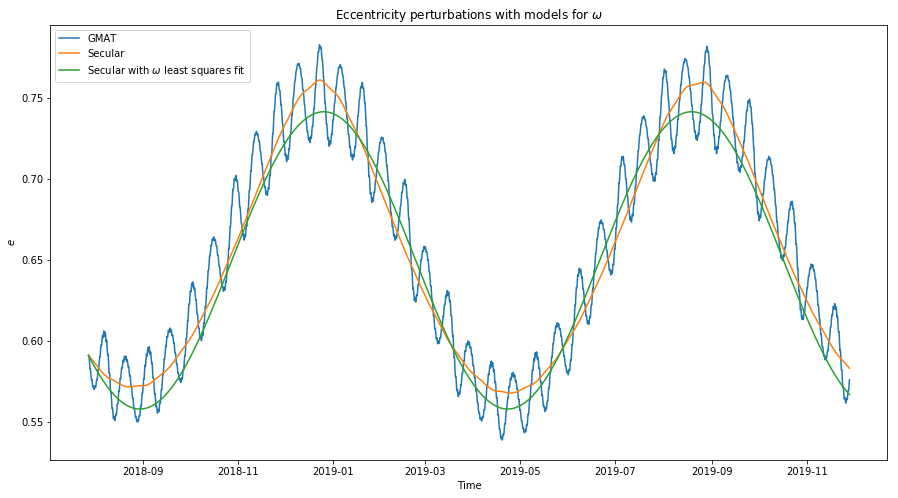

In [21]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, orbit[:,ecc])
delta_e_secular_model_lsq = 15/4*np.pi*mu_1/mu_0*(a/r_1)**3*e*np.sqrt(1-e**2)*np.sin(i_avg)**2*np.sin(2*w_lsq)
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_secular))
plt.plot(t.datetime, orbit[0,ecc]+integrate_delta(delta_e_secular_model_lsq))
plt.legend(['GMAT', 'Secular', 'Secular with $\omega$ least squares fit'])
plt.xlabel('Time')
plt.ylabel('$e$')
plt.title('Eccentricity perturbations with models for $\omega$');

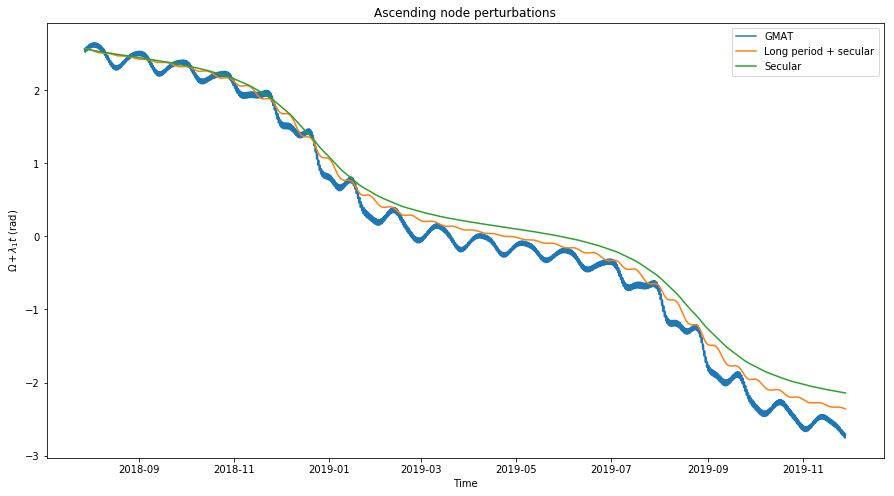

In [22]:
P_1 = 27.321661 # sidereal Lunar month
lambda_1 = 2*np.pi/P_1
Omega_est = -lambda_1 * (orbit[:,utc] - orbit[0,utc])
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, np.unwrap(Omega) - Omega_est)
delta_Omega_secular = -3/2*np.pi*mu_1/mu_0*(a/r_1)**3*np.cos(i)/np.sqrt(1-orbit[:,ecc]**2)*(1-orbit[:,ecc]**2+5*orbit[:,ecc]**2*np.sin(w)**2)
delta_Omega_complete = 3*np.pi*mu_1/mu_0*(a/r_1)**3*1/(np.sqrt(1-orbit[:,ecc]**2)*np.sin(i))*((1+4*orbit[:,ecc]**2)*beta_5*np.sin(w)+(1-orbit[:,ecc]**2)*beta_4*np.cos(w))
Omega_secular_est = Omega[0]+integrate_delta(delta_Omega_secular)
Omega_complete_est = Omega[0]+integrate_delta(delta_Omega_complete)
plt.plot(t.datetime, Omega_complete_est)
plt.plot(t.datetime, Omega_secular_est)
plt.legend(['GMAT', 'Long period + secular', 'Secular'])
plt.xlabel('Time')
plt.ylabel('$\Omega+\lambda_1 t$ (rad)')
plt.title('Ascending node perturbations');

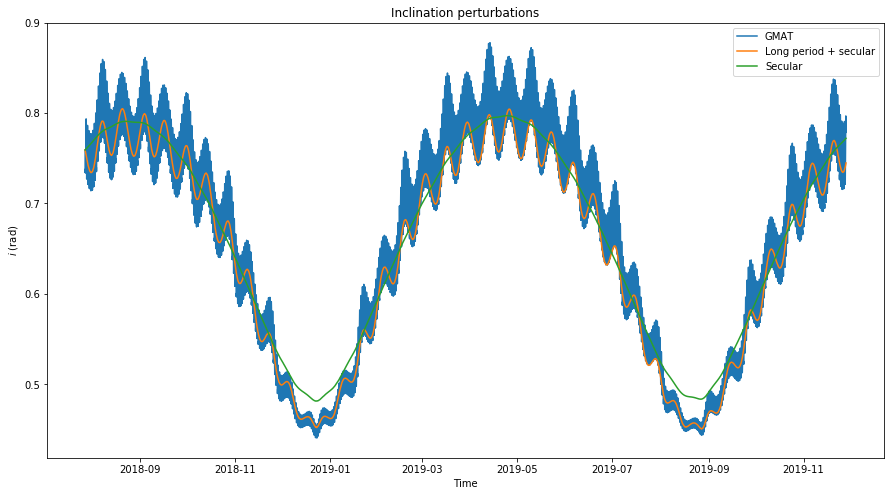

In [30]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, i)
delta_i_secular = -15/8*np.pi*mu_1/mu_0*(a/r_1)**3*e**2/np.sqrt(1-e**2)*np.sin(2*i_avg)*np.sin(2*w)
delta_i_complete = 3*np.pi*mu_1/mu_0*(a/r_1)**3*1/np.sqrt(1-orbit[:,ecc]**2)*((1+4*orbit[:,ecc]**2)*beta_5*np.cos(w)-(1-orbit[:,ecc]**2)*beta_4*np.sin(w))
i_secular_est = i[0] + integrate_delta(delta_i_secular)
i_complete_est = i[0] + integrate_delta(delta_i_complete)
plt.plot(t.datetime, i_complete_est)
plt.plot(t.datetime, i_secular_est)
plt.legend(['GMAT', 'Long period + secular', 'Secular'])
plt.xlabel('Time')
plt.ylabel('$i$ (rad)')
plt.title('Inclination perturbations');

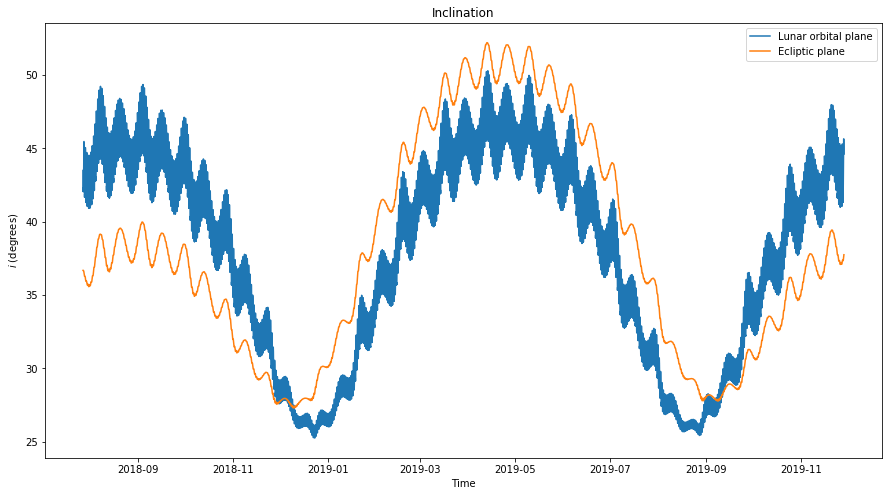

In [31]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, orbit[:,inc])
plt.plot(t.datetime, load_orbit_file('dslwp_report_simple.txt')[:,inc])
plt.legend(['Lunar orbital plane', 'Ecliptic plane'])
plt.xlabel('Time')
plt.ylabel('$i$ (degrees)')
plt.title('Inclination');

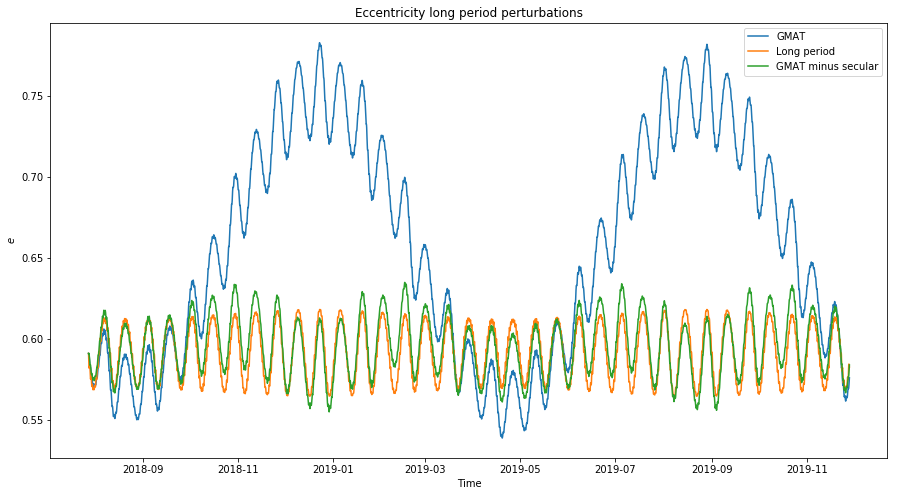

In [41]:
plt.figure(figsize = [15,8], facecolor='w')
C_a = mu_1/mu_0*(a/r_1)**3*P_1/P
D = np.sqrt(4*np.cos(i)**2*np.cos(2*w)**2 + (1+np.cos(i)**2)**2*np.sin(2*w)**2)
phi = np.arctan2((1+np.cos(i)**2)*np.sin(2*w), 2*np.cos(i)*np.cos(2*w))
delta_e_tilde = 15/16*C_a*D*e*np.sqrt(1-e**2)*(np.cos(2*Omega + phi)-np.cos(2*Omega[0]+phi[0]))
plt.plot(t.datetime, orbit[:,ecc])
plt.plot(t.datetime, delta_e_tilde + orbit[0,ecc])
plt.plot(t.datetime, orbit[:,ecc]-integrate_delta(delta_e_secular))
plt.legend(['GMAT', 'Long period', 'GMAT minus secular'])
plt.xlabel('Time')
plt.ylabel('$e$')
plt.title('Eccentricity long period perturbations');

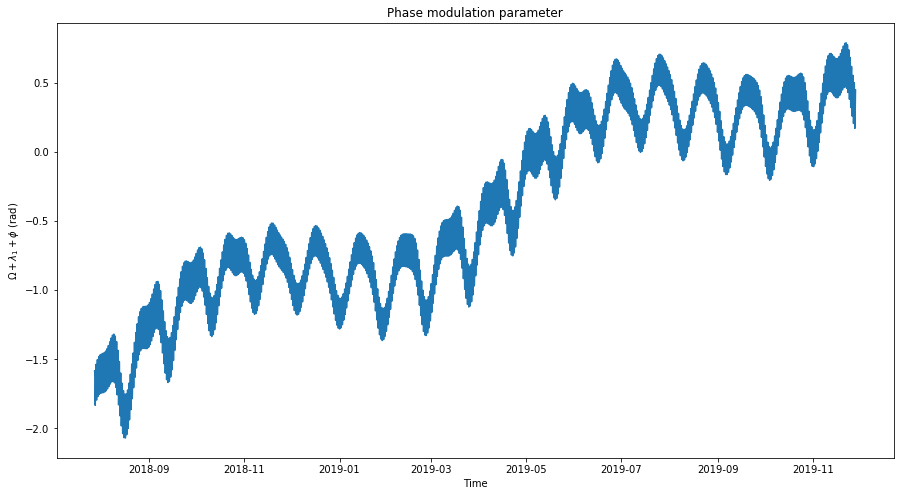

In [44]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(t.datetime, np.unwrap(2*(np.unwrap(Omega) - Omega_est) + phi)-2*np.pi)
plt.xlabel('Time')
plt.ylabel('$\Omega+\lambda_1 + \phi$ (rad)')
plt.title('Phase modulation parameter');